In [245]:
from keras import optimizers
import tensorflow as tf
import efficientnet.tfkeras as efn
from keras.models import Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard

In [246]:
# 0 : VGG16
# 1 : ResNet50
# 2 : EfficientNet_B2
CNN_name = ['VGG16', 'ResNet50', 'EfficientNet_B2']

In [247]:
CNN_Serial_number = 2

In [248]:
# NB_CLASSL: number of classes
NB_CLASS = 5

In [249]:
# Whether to perform data augmentation. 0 does not extend data. 1 Extended data
augmentation_name = ['No_Aug', 'Aug']
augmentation = 0

In [251]:
# According to the machine memory
batch_size = 32

In [252]:
# Total training rounds
EPOCH = 25

In [253]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

In [254]:
train_root = './dataset-Simpsons_Main_Characters/train_images/'
validation_root = './dataset-Simpsons_Main_Characters/test_images/'

In [255]:
# log display level
verbose = 1

In [256]:
# loss function
loss = tf.keras.losses.categorical_crossentropy

In [257]:
# optimize function
# RMSprop
# optimizer = optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=None, decay=0.0)

# Adam
# optimizer = optimizers.adam.Adam(learning_rate=0.001, beta_1=0.9, beta_2 = 0.999, epsilon=None, amsgrad = False)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

In [258]:
# Data processing
My_ImageDatagenerator = ImageDataGenerator(
    width_shift_range=0.1, 
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    rescale=1. / 255,
)

In [259]:
train_generator = My_ImageDatagenerator.flow_from_directory(
    train_root,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=batch_size,
    shuffle=True
)
valid_generator = My_ImageDatagenerator.flow_from_directory(
    validation_root,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=batch_size,
)

Found 6936 images belonging to 5 classes.
Found 404 images belonging to 5 classes.


In [260]:
import keras.applications as cnn_model
if CNN_Serial_number == 0:
    base_model = cnn_model.vgg16.VGG16(weights='./pretrained/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False)
elif CNN_Serial_number == 1:
    base_model = cnn_model.resnet.ResNet50(weights='./pretrained/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False)
elif CNN_Serial_number == 2:
    base_model = efn.EfficientNetB2(weights='./pretrained/efficientnet-b2_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5', include_top=False)
    
    
    

In [261]:
#Add global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)


In [262]:
# add a fully connected layer
x = Dense(256, activation='relu')(x)

In [263]:
# add a classifier
predictions = Dense(NB_CLASS, activation='softmax')(x)

In [264]:
#Build the complete model we need to train

model = Model(inputs=base_model.input, outputs=predictions)

In [265]:
# Migration learning, only train the last 10 layers
for layer in model.layers:
    layer.trainable = False
for i in range(-10, 0):
    model.layers[i].trainable = True

In [266]:
from keras import metrics

In [267]:
# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=['acc', metrics.Precision(), metrics.Recall()])

In [268]:
# print model structure
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 stem_conv (Conv2D)             (None, None, None,   864         ['input_9[0][0]']                
                                32)                                                               
                                                                                                  
 stem_bn (BatchNormalization)   (None, None, None,   128         ['stem_conv[0][0]']              
                                32)                                                         

                                                                                                  
 block2a_dwconv (DepthwiseConv2  (None, None, None,   864        ['block2a_expand_activation[0][0]
 D)                             96)                              ']                               
                                                                                                  
 block2a_bn (BatchNormalization  (None, None, None,   384        ['block2a_dwconv[0][0]']         
 )                              96)                                                               
                                                                                                  
 block2a_activation (Activation  (None, None, None,   0          ['block2a_bn[0][0]']             
 )                              96)                                                               
                                                                                                  
 block2a_s

 )                              144)                                                              
                                                                                                  
 block2c_activation (Activation  (None, None, None,   0          ['block2c_bn[0][0]']             
 )                              144)                                                              
                                                                                                  
 block2c_se_squeeze (GlobalAver  (None, 144)         0           ['block2c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2c_se_reshape (Reshape)   (None, 1, 1, 144)    0           ['block2c_se_squeeze[0][0]']     
                                                                                                  
 block2c_s

 block3b_se_squeeze (GlobalAver  (None, 288)         0           ['block3b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3b_se_reshape (Reshape)   (None, 1, 1, 288)    0           ['block3b_se_squeeze[0][0]']     
                                                                                                  
 block3b_se_reduce (Conv2D)     (None, 1, 1, 12)     3468        ['block3b_se_reshape[0][0]']     
                                                                                                  
 block3b_se_expand (Conv2D)     (None, 1, 1, 288)    3744        ['block3b_se_reduce[0][0]']      
                                                                                                  
 block3b_se_excite (Multiply)   (None, None, None,   0           ['block3b_activation[0][0]',     
          

                                                                                                  
 block4a_se_squeeze (GlobalAver  (None, 288)         0           ['block4a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4a_se_reshape (Reshape)   (None, 1, 1, 288)    0           ['block4a_se_squeeze[0][0]']     
                                                                                                  
 block4a_se_reduce (Conv2D)     (None, 1, 1, 12)     3468        ['block4a_se_reshape[0][0]']     
                                                                                                  
 block4a_se_expand (Conv2D)     (None, 1, 1, 288)    3744        ['block4a_se_reduce[0][0]']      
                                                                                                  
 block4a_s

                                                                                                  
 block4c_se_reduce (Conv2D)     (None, 1, 1, 22)     11638       ['block4c_se_reshape[0][0]']     
                                                                                                  
 block4c_se_expand (Conv2D)     (None, 1, 1, 528)    12144       ['block4c_se_reduce[0][0]']      
                                                                                                  
 block4c_se_excite (Multiply)   (None, None, None,   0           ['block4c_activation[0][0]',     
                                528)                              'block4c_se_expand[0][0]']      
                                                                                                  
 block4c_project_conv (Conv2D)  (None, None, None,   46464       ['block4c_se_excite[0][0]']      
                                88)                                                               
          

 block5a_se_reshape (Reshape)   (None, 1, 1, 528)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 22)     11638       ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_se_expand (Conv2D)     (None, 1, 1, 528)    12144       ['block5a_se_reduce[0][0]']      
                                                                                                  
 block5a_se_excite (Multiply)   (None, None, None,   0           ['block5a_activation[0][0]',     
                                528)                              'block5a_se_expand[0][0]']      
                                                                                                  
 block5a_project_conv (Conv2D)  (None, None, None,   63360       ['block5a_se_excite[0][0]']      
          

                                                                                                  
 block5c_se_excite (Multiply)   (None, None, None,   0           ['block5c_activation[0][0]',     
                                720)                              'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, None, None,   86400       ['block5c_se_excite[0][0]']      
                                120)                                                              
                                                                                                  
 block5c_project_bn (BatchNorma  (None, None, None,   480        ['block5c_project_conv[0][0]']   
 lization)                      120)                                                              
                                                                                                  
 block5c_d

 block6a_se_expand (Conv2D)     (None, 1, 1, 720)    22320       ['block6a_se_reduce[0][0]']      
                                                                                                  
 block6a_se_excite (Multiply)   (None, None, None,   0           ['block6a_activation[0][0]',     
                                720)                              'block6a_se_expand[0][0]']      
                                                                                                  
 block6a_project_conv (Conv2D)  (None, None, None,   149760      ['block6a_se_excite[0][0]']      
                                208)                                                              
                                                                                                  
 block6a_project_bn (BatchNorma  (None, None, None,   832        ['block6a_project_conv[0][0]']   
 lization)                      208)                                                              
          

 block6c_project_conv (Conv2D)  (None, None, None,   259584      ['block6c_se_excite[0][0]']      
                                208)                                                              
                                                                                                  
 block6c_project_bn (BatchNorma  (None, None, None,   832        ['block6c_project_conv[0][0]']   
 lization)                      208)                                                              
                                                                                                  
 block6c_drop (FixedDropout)    (None, None, None,   0           ['block6c_project_bn[0][0]']     
                                208)                                                              
                                                                                                  
 block6c_add (Add)              (None, None, None,   0           ['block6c_drop[0][0]',           
          

                                                                                                  
 block6e_project_conv (Conv2D)  (None, None, None,   259584      ['block6e_se_excite[0][0]']      
                                208)                                                              
                                                                                                  
 block6e_project_bn (BatchNorma  (None, None, None,   832        ['block6e_project_conv[0][0]']   
 lization)                      208)                                                              
                                                                                                  
 block6e_drop (FixedDropout)    (None, None, None,   0           ['block6e_project_bn[0][0]']     
                                208)                                                              
                                                                                                  
 block6e_a

 lization)                      352)                                                              
                                                                                                  
 block7b_drop (FixedDropout)    (None, None, None,   0           ['block7b_project_bn[0][0]']     
                                352)                                                              
                                                                                                  
 block7b_add (Add)              (None, None, None,   0           ['block7b_drop[0][0]',           
                                352)                              'block7a_project_bn[0][0]']     
                                                                                                  
 top_conv (Conv2D)              (None, None, None,   495616      ['block7b_add[0][0]']            
                                1408)                                                             
          

In [269]:
import time
# log storage path
now = int(time.time())
timeArray = time.localtime(now)
otherStyleTime = time.strftime("%Y-%m-%d-%H-%M-%S", timeArray)
log_dir = './logs/' + CNN_name[CNN_Serial_number] + '_'+augmentation_name[augmentation]+'_'+otherStyleTime


In [270]:
tbCallBack = TensorBoard(log_dir=log_dir, histogram_freq=1, update_freq="epoch", )

In [271]:
#Save path of optimal model
filePath = './' + CNN_name[CNN_Serial_number] + '_'+augmentation_name[augmentation]+'_best.h5'


In [272]:
#If there is an upgrade, it will be overwritten once
checkpoint = ModelCheckpoint(filePath, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_freq='epoch')



In [273]:
callbacks_list = [checkpoint, tbCallBack]


In [274]:
# train on the dataset
history = model.fit(train_generator, 
                    validation_data=valid_generator,
                    epochs=EPOCH,
                    steps_per_epoch=train_generator.n / batch_size,
                    validation_steps=valid_generator.n / batch_size,
                    verbose = verbose,
                    callbacks = callbacks_list)

Epoch 1/25


2023-05-01 13:58:28.245037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


217/216 [==============================] - ETA: 0s - loss: 1.5172 - acc: 0.3480 - precision_2: 0.7636 - recall_2: 0.0061

2023-05-01 14:03:29.645755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_acc improved from -inf to 0.39109, saving model to ./EfficientNet_B2_No_Aug_best.h5
216/216 [==============================] - 322s 1s/step - loss: 1.5172 - acc: 0.3480 - precision_2: 0.7636 - recall_2: 0.0061 - val_loss: 1.4967 - val_acc: 0.3911 - val_precision_2: 1.0000 - val_recall_2: 0.0074
Epoch 2/25
217/216 [==============================] - ETA: 0s - loss: 1.3028 - acc: 0.5506 - precision_2: 0.9062 - recall_2: 0.0738
Epoch 2: val_acc improved from 0.39109 to 0.46535, saving model to ./EfficientNet_B2_No_Aug_best.h5
216/216 [==============================] - 312s 1s/step - loss: 1.3028 - acc: 0.5506 - precision_2: 0.9062 - recall_2: 0.0738 - val_loss: 1.3677 - val_acc: 0.4653 - val_precision_2: 0.8636 - val_recall_2: 0.0941
Epoch 3/25
217/216 [==============================] - ETA: 0s - loss: 1.1431 - acc: 0.6348 - precision_2: 0.9198 - recall_2: 0.1753
Epoch 3: val_acc improved from 0.46535 to 0.51980, saving model to ./EfficientNet_B2_No_Aug_best.h5
216/216 [=====

Epoch 21/25
217/216 [==============================] - ETA: 0s - loss: 0.3108 - acc: 0.9072 - precision_2: 0.9434 - recall_2: 0.8574
Epoch 21: val_acc did not improve from 0.75000
216/216 [==============================] - 328s 2s/step - loss: 0.3108 - acc: 0.9072 - precision_2: 0.9434 - recall_2: 0.8574 - val_loss: 0.7149 - val_acc: 0.7450 - val_precision_2: 0.8275 - val_recall_2: 0.7005
Epoch 22/25
217/216 [==============================] - ETA: 0s - loss: 0.3040 - acc: 0.9070 - precision_2: 0.9444 - recall_2: 0.8613
Epoch 22: val_acc did not improve from 0.75000
216/216 [==============================] - 335s 2s/step - loss: 0.3040 - acc: 0.9070 - precision_2: 0.9444 - recall_2: 0.8613 - val_loss: 0.7315 - val_acc: 0.7327 - val_precision_2: 0.8299 - val_recall_2: 0.6881
Epoch 23/25
217/216 [==============================] - ETA: 0s - loss: 0.2826 - acc: 0.9167 - precision_2: 0.9482 - recall_2: 0.8717
Epoch 23: val_acc did not improve from 0.75000
216/216 [===========================

In [276]:
trained_filePath = './p_trained/' + CNN_name[CNN_Serial_number] + '_'+augmentation_name[augmentation]+'_'+otherStyleTime+'_best.h5'


'./p_trained/EfficientNet_B2_No_Aug_2023-05-01-13-58-18_best.h5'

In [277]:
from joblib import Parallel, delayed
import joblib


# Save the model as a pickle in a file
joblib.dump(model, trained_filePath)

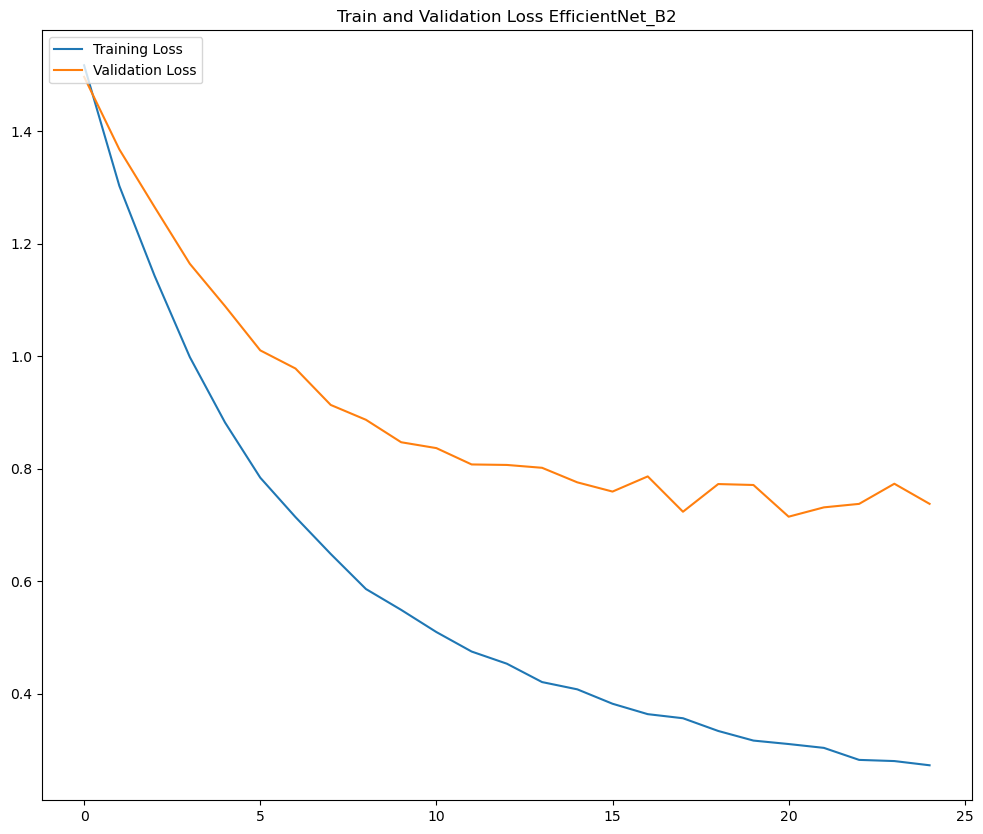

In [289]:
# Visualization of Accuracy and loss
# Loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCH)

plt.figure(figsize=(12, 10))
plt.plot(epochs_range, train_loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc='upper left')
plt.title('Train and Validation Loss ' + CNN_name[CNN_Serial_number])

plt.show()

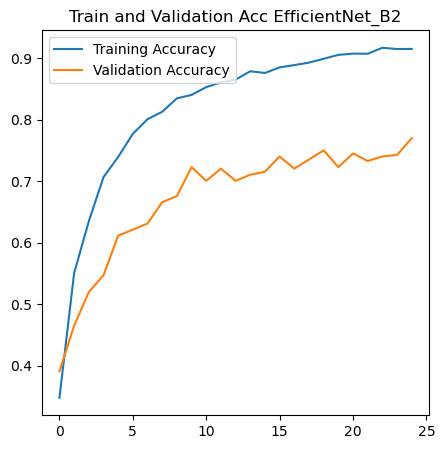

In [290]:
# Accuracy
train_acc = history.history['acc']
val_acc = history.history['val_acc']

epochs_range = range(EPOCH)

plt.figure(figsize=(5, 5))
plt.plot(epochs_range, train_acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc='upper left')
plt.title('Train and Validation Acc ' + CNN_name[CNN_Serial_number])

plt.show()

In [297]:
# Image test

test_root = './test/'
# Load the model from the file
from_model = joblib.load(trained_filePath)
test_datagen = ImageDataGenerator(
    rescale=1. / 255
)
test_genertor = test_datagen.flow_from_directory(
    test_root,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=batch_size,
)

result = from_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc', metrics.Precision(), metrics.Recall()])



Found 5 images belonging to 5 classes.


In [314]:
model.evaluate(test_genertor, 
               max_queue_size=10, workers=1, use_multiprocessing=False, verbose=verbose)



2023-05-01 17:16:01.788108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 287ms/step - loss: 1.1024 - acc: 0.8000 - precision_2: 0.8000 - recall_2: 0.8000


[1.1024341583251953, 0.800000011920929, 0.800000011920929, 0.800000011920929]

In [310]:
print(type(test_genertor.n / batch_size))
print(test_genertor.n / batch_size)

<class 'float'>
0.15625


In [ ]:
# confusion matrix
display_labels = range(0, NB_CLASS)

In [ ]:
show_figure = False
normalization = True

In [315]:
def test(picname, model):
    keras.backend.clear_session()
    img_path = picname
    test_image = image.load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)
    test_image_test_image/255
    predict = model.predict(tesy_image)
    preds = np.argmax(predict, axis=1)[0]
    return preds

min: 0.0 max: 1.0


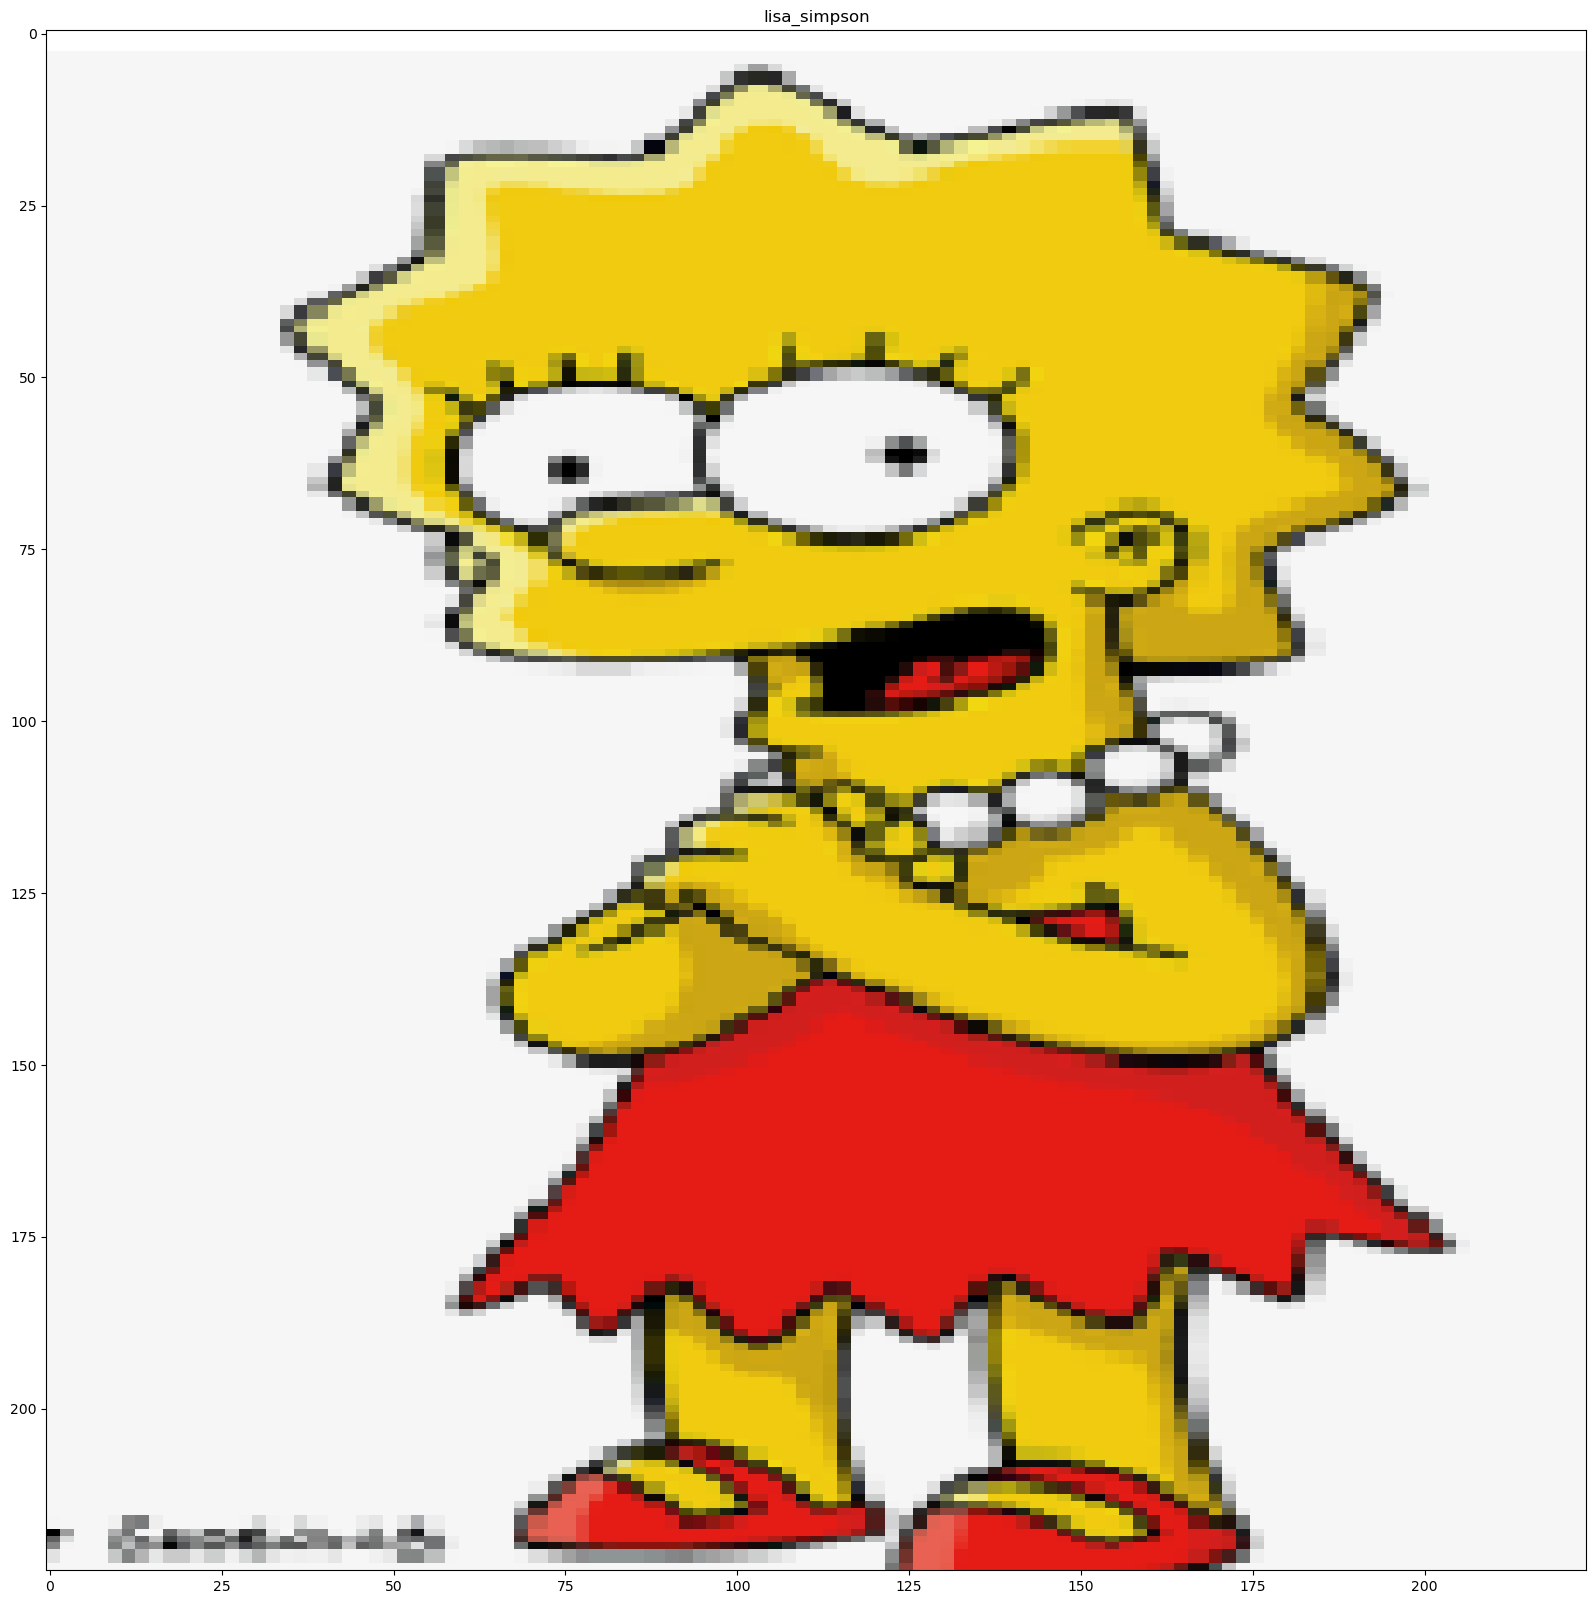

['bart_simpson', 'homer_simpson', 'lisa_simpson', 'maggie_simpson', 'marge_simpson']


In [359]:
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
    labels[v] = k

# should be a strangely colored image (due to VGG weights being BGR)
for x, y in test_gen:
    print("min:", x[0].min(), "max:", x[0].max())
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    plt.show()
    break
print(labels)

In [317]:
test_gen = test_datagen.flow_from_directory(test_root, target_size=(IMG_WIDTH, IMG_HEIGHT))
print(test_gen.class_indices)

Found 5 images belonging to 5 classes.
{'bart_simpson': 0, 'homer_simpson': 1, 'lisa_simpson': 2, 'maggie_simpson': 3, 'marge_simpson': 4}


In [324]:
import itertools


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.rcParams["figure.figsize"] = (40,20)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")
  
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [330]:
from glob import glob

# useful for getting number of files
image_files = glob(train_root + '/*/*.jp*g')
test_image_files = glob(test_root + '/*/*.jp*g')

# useful for getting number of classes
folders = glob(train_root + '/*')
print(folders)

['./dataset-Simpsons_Main_Characters/train_images/maggie_simpson', './dataset-Simpsons_Main_Characters/train_images/marge_simpson', './dataset-Simpsons_Main_Characters/train_images/bart_simpson', './dataset-Simpsons_Main_Characters/train_images/lisa_simpson', './dataset-Simpsons_Main_Characters/train_images/homer_simpson']


In [366]:
import os
import json
import glob
from prettytable import PrettyTable





class ConfusionMatrix(object):
    def __init__(self, num_classes: int, labels: list):
        self.matrix = np.zeros((num_classes, num_classes))
        self.num_classes = num_classes
        self.labels = labels

    def update(self, preds, labels):
        for p, t in zip(preds, labels):
            self.matrix[p, t] += 1

    def summary(self):
        # calculate accuracy
        sum_TP = 0
        for i in range(self.num_classes):
            sum_TP += self.matrix[i, i]
        acc = sum_TP / np.sum(self.matrix)
        print("the model accuracy is ", acc)

        # precision, recall, specificity
        table = PrettyTable()
        table.field_names = ["", "Precision", "Recall", "Specificity", 'F1']
        for i in range(self.num_classes):
            TP = self.matrix[i, i]
            FP = np.sum(self.matrix[i, :]) - TP
            FN = np.sum(self.matrix[:, i]) - TP
            TN = np.sum(self.matrix) - TP - FP - FN
            Precision = round(TP / (TP + FP), 3) if TP + FP != 0 else 0.
            Recall = round(TP / (TP + FN), 3) if TP + FN != 0 else 0.
            Specificity = round(TN / (TN + FP), 3) if TN + FP != 0 else 0.
            F1 = round(2*Precision*Recall/(Precision+Recall), 3) if Precision+Recall != 0 else 0.
            table.add_row([self.labels[i], Precision, Recall, Specificity, F1])
        print(table)

    def plot(self):
        matrix = self.matrix
        print(matrix)
        plt.imshow(matrix, cmap=plt.cm.Blues)

        plt.xticks(range(self.num_classes), self.labels, rotation=45)
        plt.yticks(range(self.num_classes), self.labels)
        plt.colorbar()
        plt.xlabel('True Labels')
        plt.ylabel('Predicted Labels')
        plt.title('Confusion matrix')

        thresh = matrix.max() / 2
        for x in range(self.num_classes):
            for y in range(self.num_classes):
                info = int(matrix[y, x])
                plt.text(x, y, info,
                         verticalalignment='center',
                         horizontalalignment='center',
                         color="white" if info > thresh else "black")
        plt.tight_layout()
        plt.show()


Found 404 images belonging to 5 classes.


  0%|                                                    | 0/13 [00:00<?, ?it/s]2023-05-01 18:32:30.653347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [32,224,224,3]
	 [[{{node Placeholder/_0}}]]
  8%|███▍                                        | 1/13 [00:02<00:25,  2.11s/it]2023-05-01 18:32:32.722376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [32,224,224,3]
	 [[{{node Placeholder/_0}}]]
 15%|██████▊                                     | 2/13 [00:03<00:21,  1.98s/it]2023-05-01 18:32:34.572668: I tensorflow/core/common_runti

[[69.  0.  2.  4.  9.]
 [ 8. 80.  5. 10. 15.]
 [ 2.  0. 64. 48.  5.]
 [ 2.  0.  7. 15.  0.]
 [ 0.  1.  2.  4. 52.]]


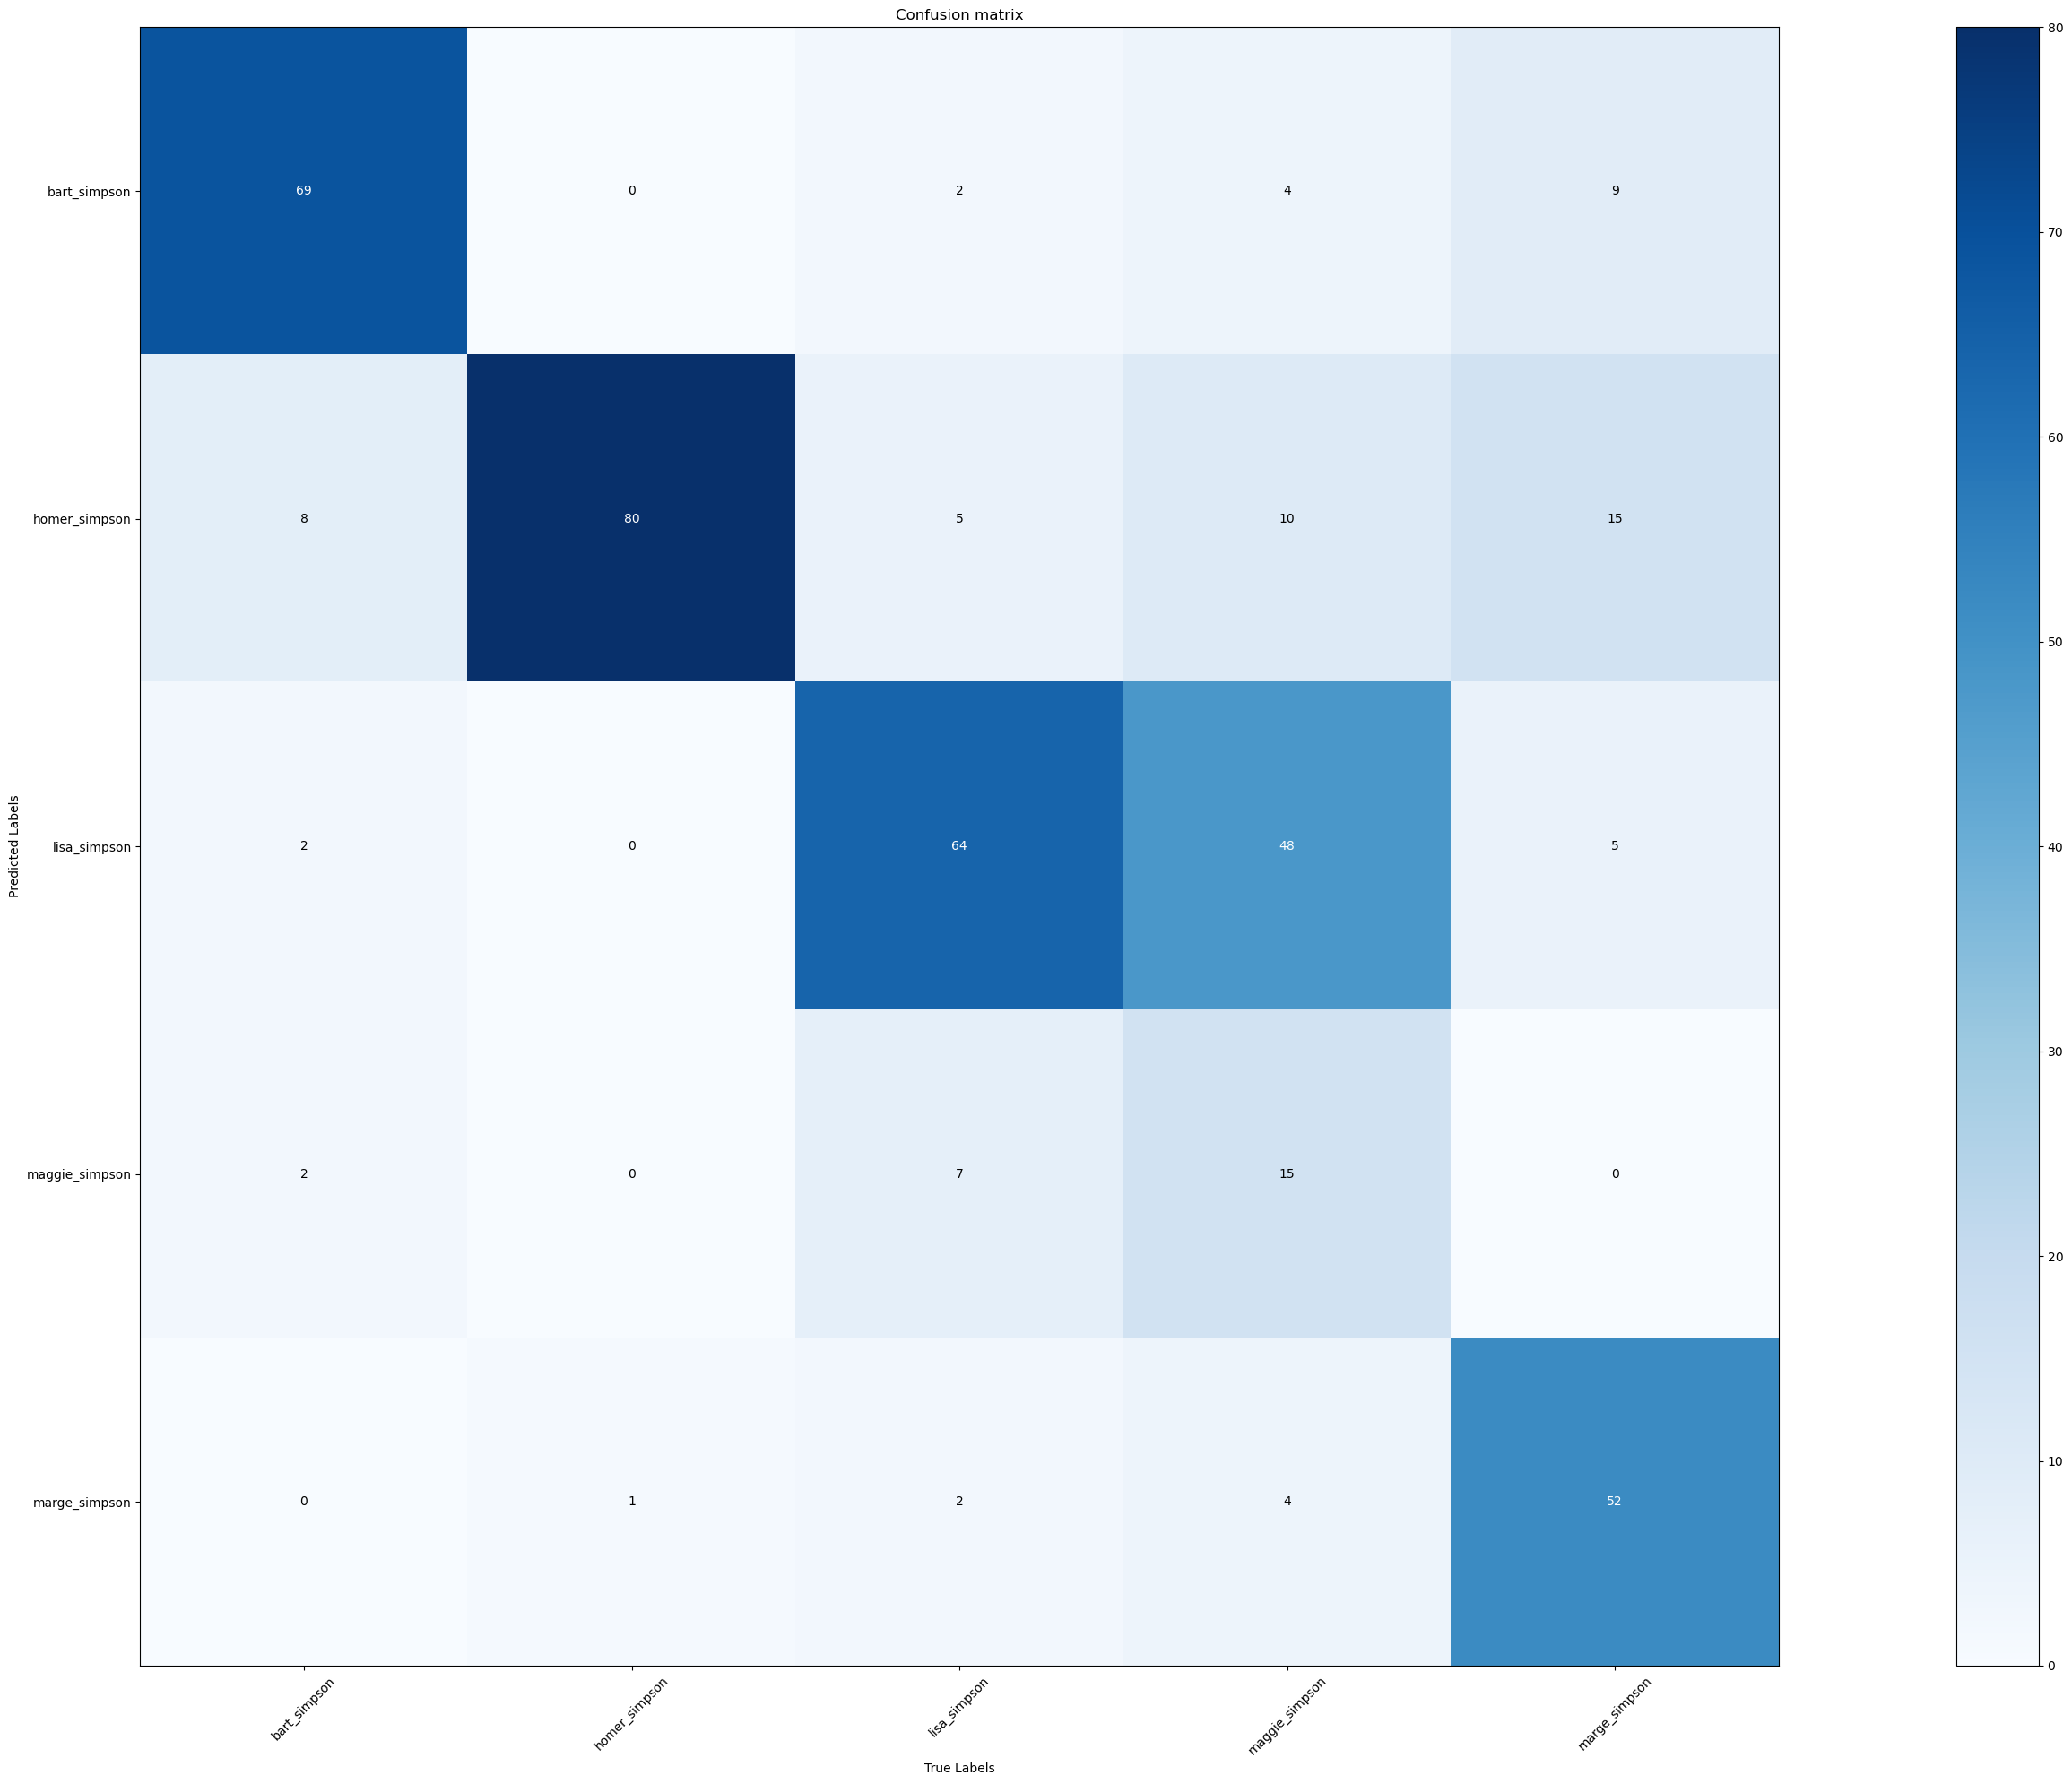

the model accuracy is  0.693069306930693
+----------------+-----------+--------+-------------+-------+
|                | Precision | Recall | Specificity |   F1  |
+----------------+-----------+--------+-------------+-------+
|  bart_simpson  |   0.821   | 0.852  |    0.954    | 0.836 |
| homer_simpson  |   0.678   | 0.988  |    0.882    | 0.804 |
|  lisa_simpson  |   0.538   |  0.8   |     0.83    | 0.643 |
| maggie_simpson |   0.625   | 0.185  |    0.972    | 0.285 |
| marge_simpson  |   0.881   | 0.642  |    0.978    | 0.743 |
+----------------+-----------+--------+-------------+-------+


In [367]:

from tqdm import tqdm
def pre_function(img):
    # img = im.open('test.jpg')
    # img = np.array(img).astype(np.float32)
    img = img / 255.
    img = (img - 0.5) * 2.0
    return img


# data generator with data augmentation
validation_image_generator = ImageDataGenerator(preprocessing_function=pre_function)

val_data_gen = validation_image_generator.flow_from_directory(directory=validation_root,
                                                              batch_size=batch_size,
                                                              shuffle=False,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical')
# img, _ = next(train_data_gen)
total_val = val_data_gen.n
confusion = ConfusionMatrix(num_classes=NB_CLASS, labels=labels)

# validate
for step in tqdm(range(math.ceil(total_val / batch_size))):
    val_images, val_labels = next(val_data_gen)
    results = from_model.predict_on_batch(val_images)
    results = tf.keras.layers.Softmax()(results).numpy()
    results = np.argmax(results, axis=-1)
    labels1 = np.argmax(val_labels, axis=-1)
    confusion.update(results, labels1)
confusion.plot()
confusion.summary()

In [360]:
print(NB_CLASS)
print(labels)
print(len(labels))

5
['bart_simpson', 'homer_simpson', 'lisa_simpson', 'maggie_simpson', 'marge_simpson']
5
